# Ensemble Learning Multi-Class Classification

This notebook contains the pipeline that allows to perform classification experiments of the Multi-Class version of this problem. **Cardboard**, **Metal**, **Paper**, **Glass**, and **Plastic** are the classes that are considered in this set of experiments. The used <u>data set</u> may be found in the following [Kaggle Repository](https://www.kaggle.com/asdasdasasdas/garbage-classification). 

clean_research_practice1_version.ipynb set the baseline in order to work with in this notebook, the binary classification version of the problem is worked in there. In case of doubts, this should be the reference to be consulted.

# Imports


In [1]:
# %%capture
# # Import helper functions
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/file_management.py
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/evaluation_functions.py
# !wget https://raw.githubusercontent.com/daoterog/Solid_Domestic_Waste_Image_Classification/main/helper_functions/image_processing.py

In [1]:
import os
import errno

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier

from file_management import bring_data, walk_through_dir, copy_folder
from image_processing import (center_image_IDG, get_visual_dictionary, 
                              get_histogram, applypca, applynmf)
from evaluation_functions import (hyperparametertunning, multiple_model_hyperparameter_tuning, 
                                  learningcurve, plotlearningcurve, multiclass_CV, 
                                  print_wrong_predictions, get_sub_model_predictions,
                                  get_multiple_model_predictions)

import tensorflow as tf

# from google.colab import drive
# drive.mount('/content/drive/', force_remount=True)

# Preprocessing

## Load the Data

In [2]:
# path_list = ['/content/drive/MyDrive/PI2/data/cardboard.zip',
#             '/content/drive/MyDrive/PI2/data/metal.zip',
#              '/content/drive/MyDrive/PI2/data/glass.zip',
#              '/content/drive/MyDrive/PI2/data/paper.zip',
#              '/content/drive/MyDrive/PI2/data/plastic.zip']

# # Unzip the data
# bring_data(path_list=path_list)

# How many images/classes are there?
walk_through_dir("data/data_augmentation")

There are 5 directories and 0 images in 'data/data_augmentation'.
There are 0 directories and 503 images in 'data/data_augmentation\cardboard'.
There are 0 directories and 597 images in 'data/data_augmentation\glass'.
There are 0 directories and 509 images in 'data/data_augmentation\metal'.
There are 0 directories and 694 images in 'data/data_augmentation\paper'.
There are 0 directories and 582 images in 'data/data_augmentation\plastic'.


## Run Processing Functions

In [18]:
# Image paths
image_dir = '/content/data/'

IMG_SIZE = (112, 112)
COLOR_MODE = "grayscale"
CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic']
BATCH_SIZE = 32
CLASS_MODE = 'sparse'
SHUFFLE = False

params = dict(target_size=IMG_SIZE, color_mode=COLOR_MODE, 
              class_mode=CLASS_MODE, shuffle=SHUFFLE)

# Create Image Data Generator
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=center_image_IDG)

# Processing techniques included
data_gen = image_generator.flow_from_directory(directory='data/data_augmentation', 
                                               batch_size = 2885,
                                               classes=CLASSES,
                                               **params)

# Extracting train and test images and labels
images, labels = data_gen.next()

# Convert labels into dataframe to extract random samples
labels_df = pd.DataFrame(labels)
N = labels_df.value_counts().min()

# Extract random samples of the data with their indices and concatenate them
cardboard = labels_df[labels_df[0] == 0].sample(N).index.tolist()
glass = labels_df[labels_df[0] == 1].sample(N).index.tolist()
metal = labels_df[labels_df[0] == 2].sample(N).index.tolist() 
paper = labels_df[labels_df[0] == 3].sample(N).index.tolist()
plastic = labels_df[labels_df[0] == 4].sample(N).index.tolist()
indexes = cardboard + glass + metal + paper + plastic
indexes = np.sort(indexes)

# Choose balanced images
balanced_images = images[indexes]
balanced_images = balanced_images.reshape(balanced_images.shape[:-1])
balanced_labels = labels[indexes]
image_filenames = np.array(data_gen.filenames)[indexes]

Found 2885 images belonging to 5 classes.


## Bag of Features

In [19]:
# BoF
patch_size, step_size = 10,3
n_words = 40

# Bag of Features
vdict = get_visual_dictionary(balanced_images, patch_size, step_size, n_words)
Xh = [get_histogram(img, patch_size, step_size, vdict) \
      for img in balanced_images]
Xh = np.array(Xh)

Xh = pd.DataFrame(Xh)
Xh.fillna(0, inplace = True)

# Assign y
y = balanced_labels

In [20]:
np.count_nonzero(Xh.to_numpy() == 0)/(Xh.shape[0]*Xh.shape[1]) # 40

0.21895626242544733

## Print N Images

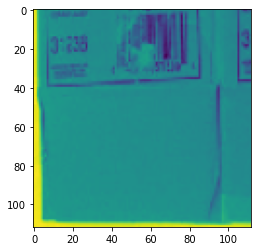

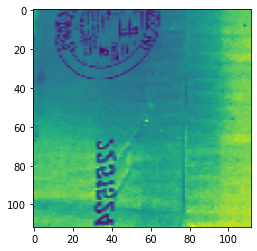

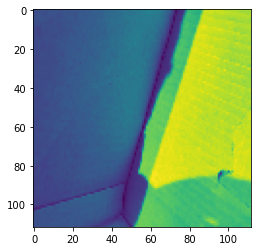

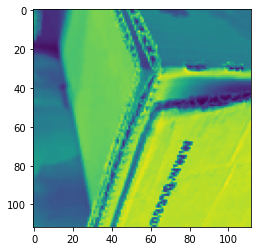

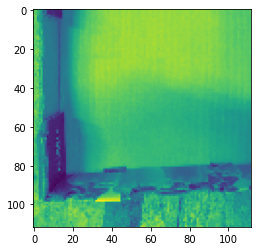

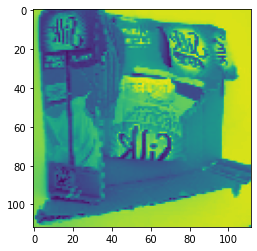

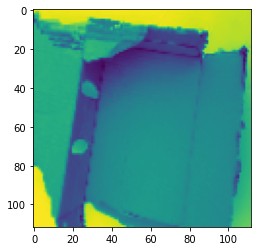

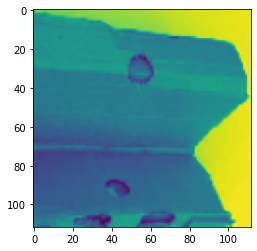

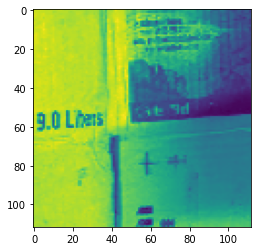

In [21]:
n = 10

for img in balanced_images[1:n]:
    plt.imshow(img[:,:])
    plt.show()

## Dimension Reduction

In [22]:
# Apply PCA
Xh_pca, pca = applypca(Xh) 

variance = pca.explained_variance_ratio_

suma = 0
cont = 0
while suma < 0.8:
  suma += variance[cont]
  cont += 1

Xh_pca80 = Xh_pca.iloc[:,:cont]

# Apply NMF
Xh_nmf, nmf = applynmf(Xh, cont)
print("Original BoF shape:",Xh.shape)
print("BoF PCA shape:",Xh_pca.shape)
print("BoF PCA80 shape",Xh_pca80.shape)
print("BoF NMF shape",Xh_nmf.shape)

Original BoF shape: (2515, 40)
BoF PCA shape: (2515, 40)
BoF PCA80 shape (2515, 8)
BoF NMF shape (2515, 8)


C:\Users\danie\miniconda3\envs\ds\lib\site-packages\sklearn\decomposition\_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


# Model Evaluation

## Experiment Setting

In [49]:
# Create Directory
root = 'experiments/'
# destination = '/content/drive/MyDrive/PI2/experiments'

try:
    os.mkdir(root)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise

# Create Experiment Directory
experiment = str(input('Type Experiment Name: '))
path = root + experiment
try:
    os.mkdir(path)
except OSError as e:
    if e.errno == errno.EEXIST:
        print('Directory already exist')
    else:
        raise
model_name = str(input('Type Model Name: '))

# Create training dictionary
X_dict = {'BoF':Xh,'BoF-PCA':Xh_pca,'BoF-PCA80':Xh_pca80,'BoF-NMF':Xh_nmf}

Directory already exist
Type Experiment Name: ensemble_aug_Ada
Type Model Name: AdaBoost


## Sub-Model Hyperparameter Tuning

In [24]:
%%capture

# Classifier - AdaBoost
tree = DecisionTreeClassifier(max_depth=8)
ada = AdaBoostClassifier(tree)
ada_hyperparameters = {'n_estimators': [100, 250],
                  'learning_rate': [0.75, 1.5]}

# Classifier - Random Forest
rf = RandomForestClassifier(n_jobs=-1)
rf_hyperparameters = {'n_estimators': [100, 250, 500],
                  'max_depth': [4, 8, 16, 32],
                  'criterion': ['gini', 'entropy']}

# Classifier - Gaussian Naive Bayes
gnb = GaussianNB()
gnb_hyperparameters = {}

# # Classifier - SVM
svm = SVC(probability=True)
svm_hyperparameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'sigmoid', 'linear']}

# Classifier - Logistic
logistic = LogisticRegression(multi_class='multinomial')
logistic_hyperparameters = {'C': np.logspace(0,4,10), 
                   'penalty': ['l1','l2','elasticnet','none']}

model_list = [rf, logistic, gnb, svm, ada]
hyperparameter_list = [rf_hyperparameters, logistic_hyperparameters, 
                       gnb_hyperparameters, svm_hyperparameters, ada_hyperparameters]

# Tune Hyperparameters
param_dict_list = multiple_model_hyperparameter_tuning(model_list, 
                                                       hyperparameter_list, 
                                                       X_dict, y, 5, 'f1_macro')

# param_dict, param_title_dictionary = hyperparametertunning(model, X_dict, y, 
#                                                            hyperparameters, 5, 
#                                                            'f1_macro')

## Make predictions with Sub-Model

In [25]:
%%capture
new_X_dict = get_multiple_model_predictions(model_list, 5, X_dict, y, param_dict_list, 
                                            image_filenames)

# new_X_dict = get_sub_model_predictions(model, 5, X_dict, y, param_dict, image_filenames)

## Main Model Hyperparameter Tuning

In [50]:
%%capture

# Classifier - AdaBoost
tree = DecisionTreeClassifier(max_depth=8)
model = AdaBoostClassifier(tree)
hyperparameters = {'n_estimators': [50, 100, 250],
                  'learning_rate': [0.5, 1, 1.5]}

# # Classifier - Random Forest
# model = RandomForestClassifier(n_jobs=-1)
# hyperparameters = {'n_estimators': [100, 250, 500],
#                   'max_depth': [4, 8, 16, 32],
#                   'criterion': ['gini', 'entropy']}

# # Classifier - Gaussian Naive Bayes
# model = GaussianNB()
# hyperparameters = {}

# Classifier - SVM
# model = SVC(probability=True)
# hyperparameters = {'C': [0.1, 1, 10, 100, 1000],
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'sigmoid', 'linear']}

# Classifier - Logistic
# model = LogisticRegression(multi_class='multinomial')
# hyperparameters = {'C': np.logspace(0,4,10), 
#                    'penalty': ['l1','l2','elasticnet','none']}

# Tune Hyperparameters
param_dict, param_title_dictionary = hyperparametertunning(model, new_X_dict, y, 
                                                           hyperparameters, 5, 
                                                           'f1_macro')

## Learning Curves

In [51]:
%%capture 
(train_sizes_dict, train_scores_mean_dict, train_scores_std_dict, 
  test_scores_mean_dict, 
  test_scores_std_dict) = learningcurve(model, new_X_dict, y, 
                                        5, param_dict, 'f1_macro', 
                                        np.linspace(0.1,1,50))

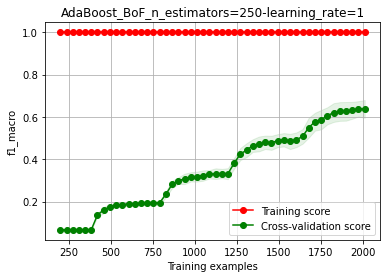

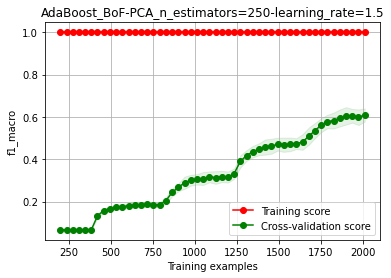

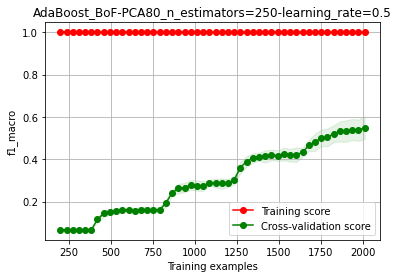

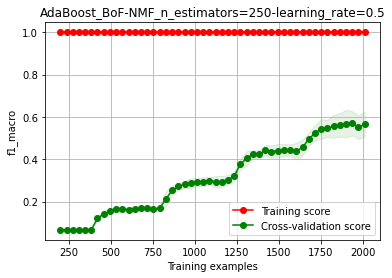

In [52]:
plotlearningcurve(model_name, param_dict, param_title_dictionary, 'f1_macro', 
                  train_sizes_dict, train_scores_mean_dict, 
                  train_scores_std_dict, test_scores_mean_dict,
                  test_scores_std_dict, path)

## Evaluating Performance Across Classes

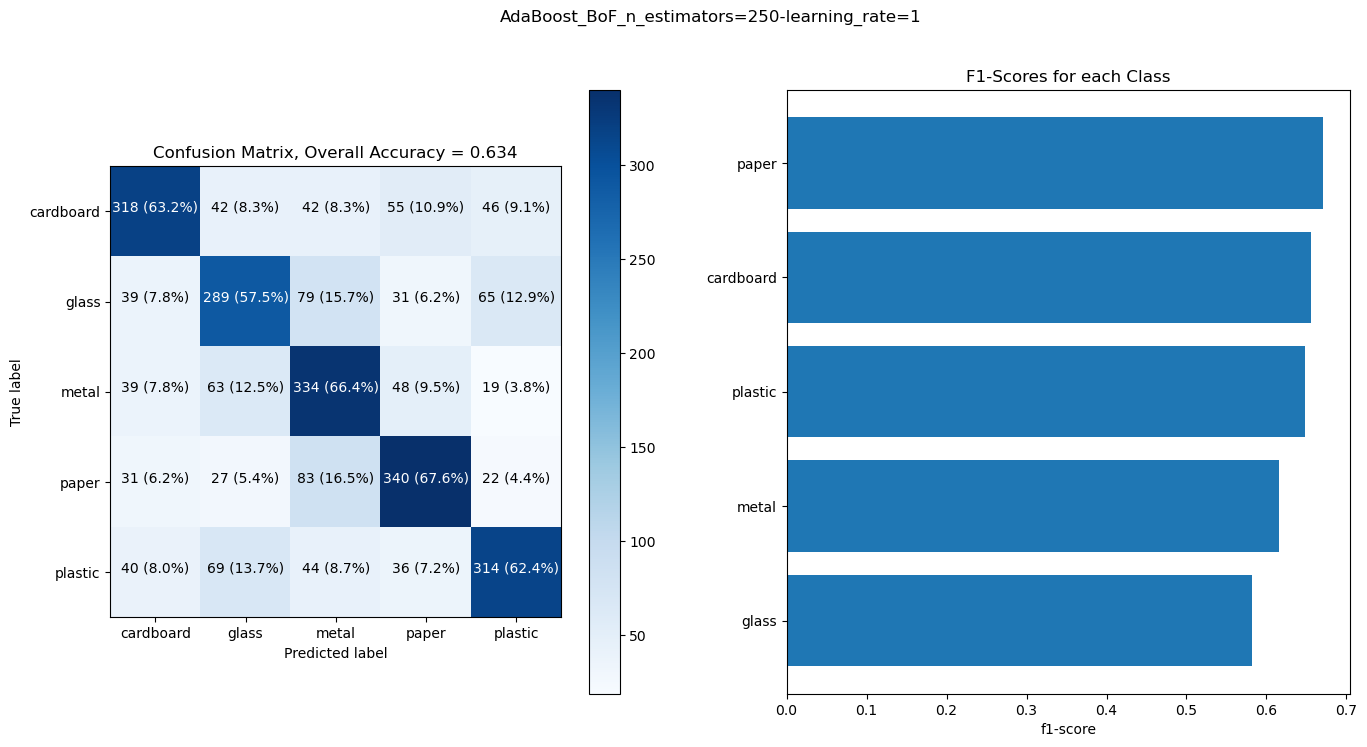

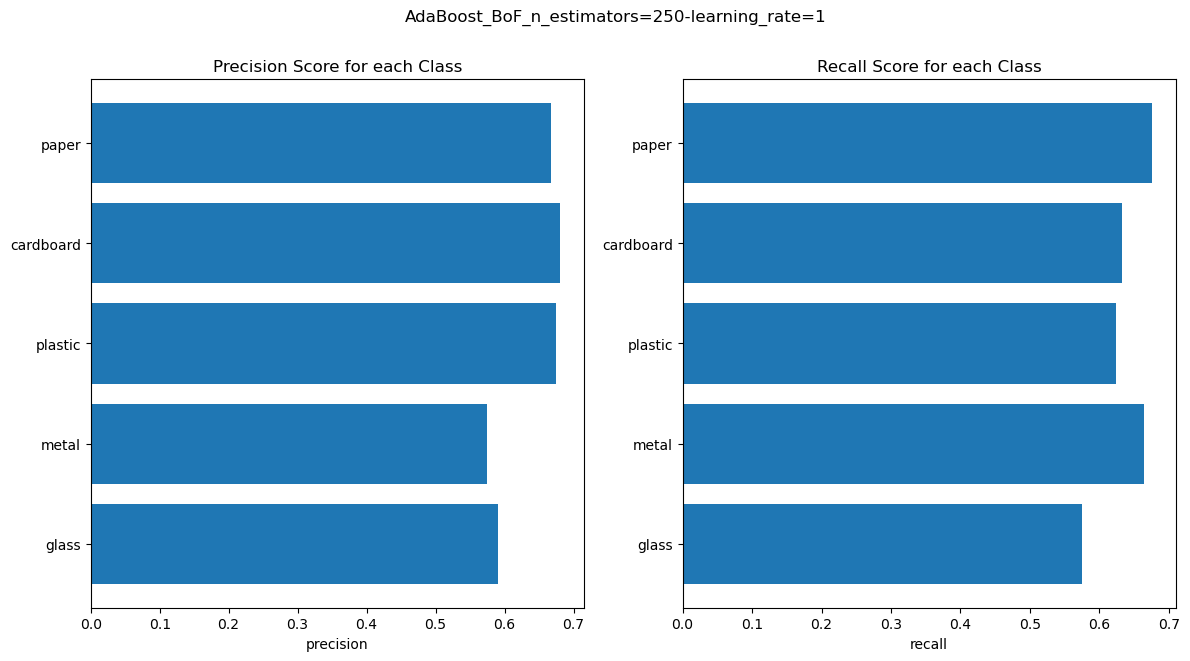

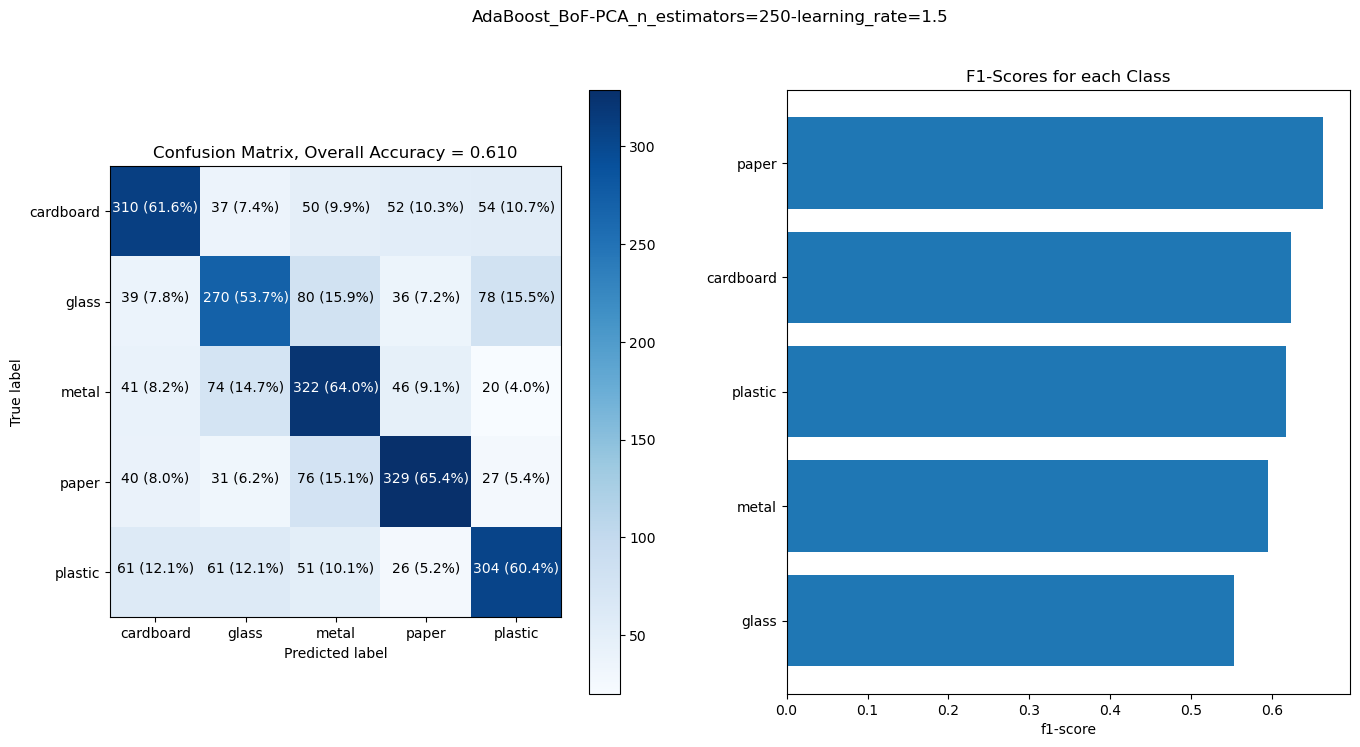

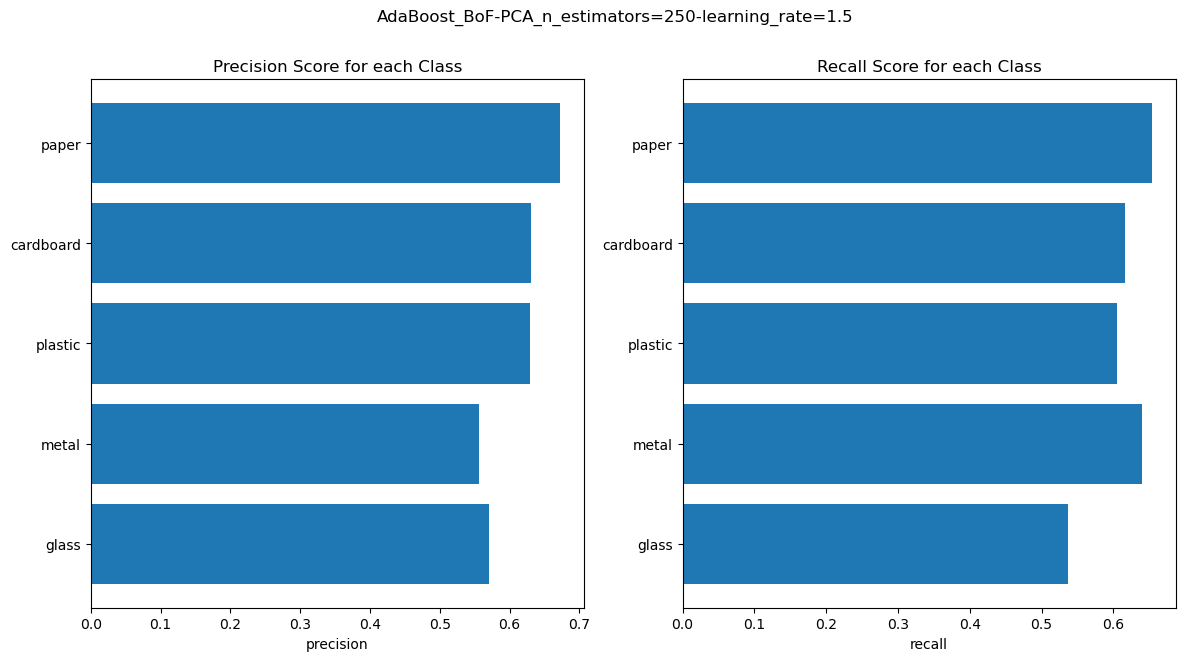

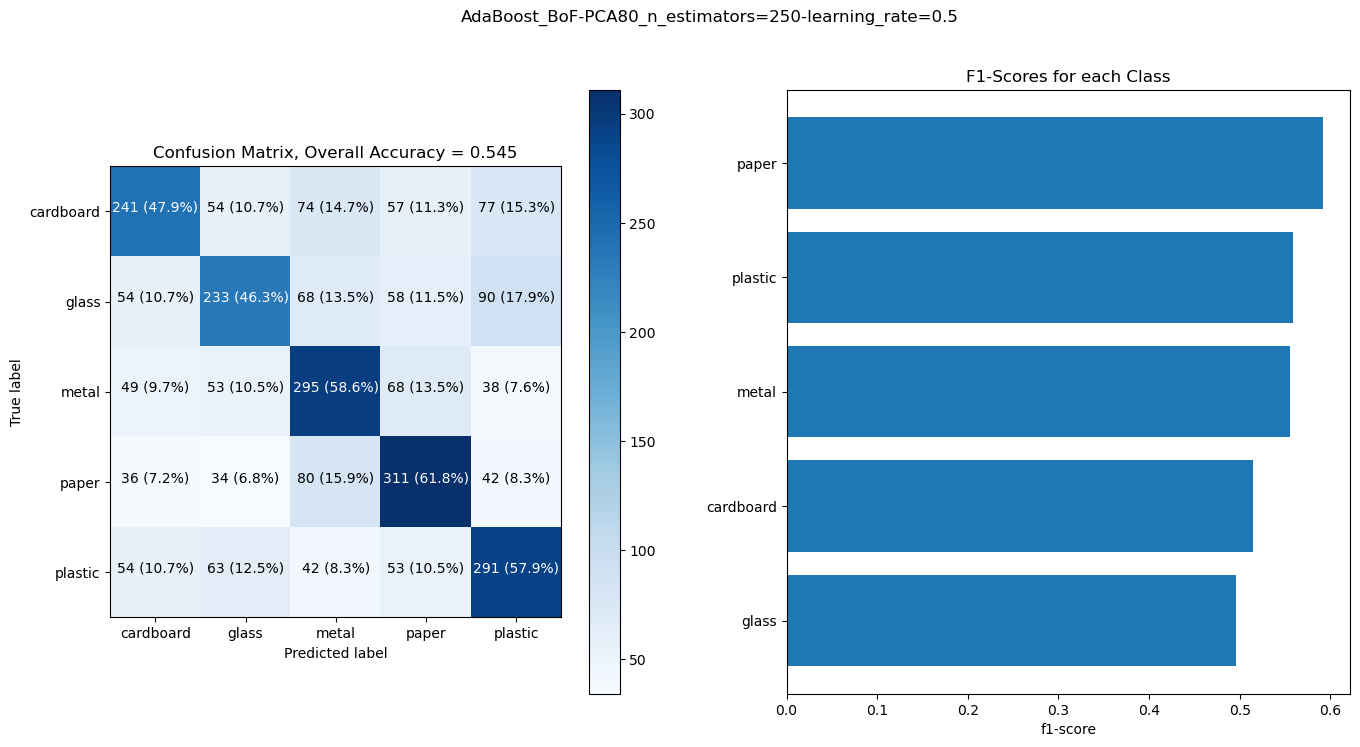

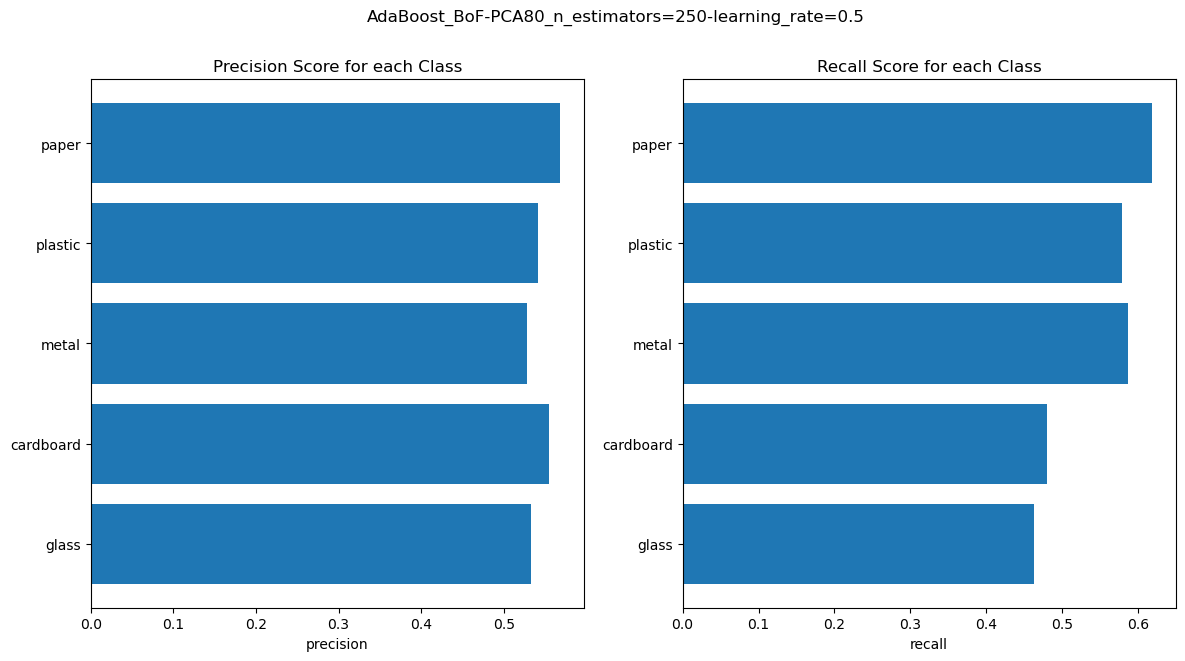

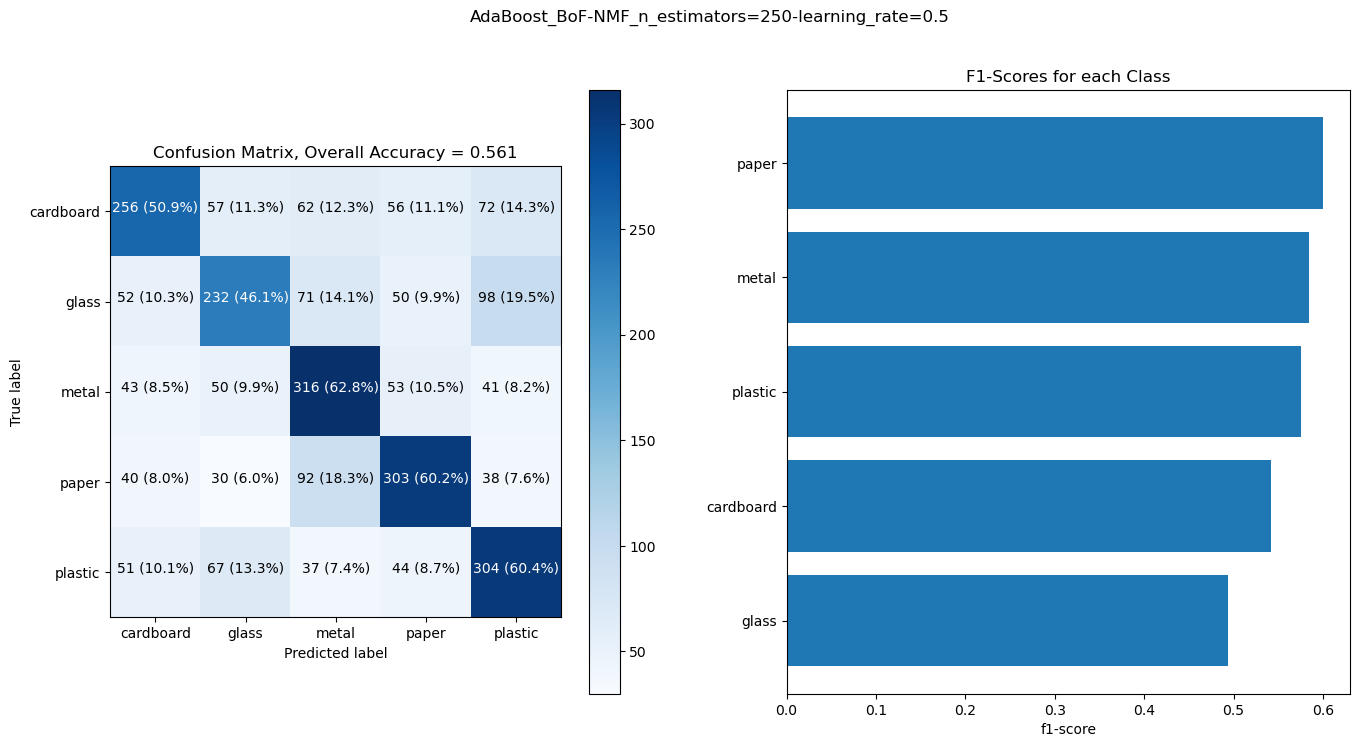

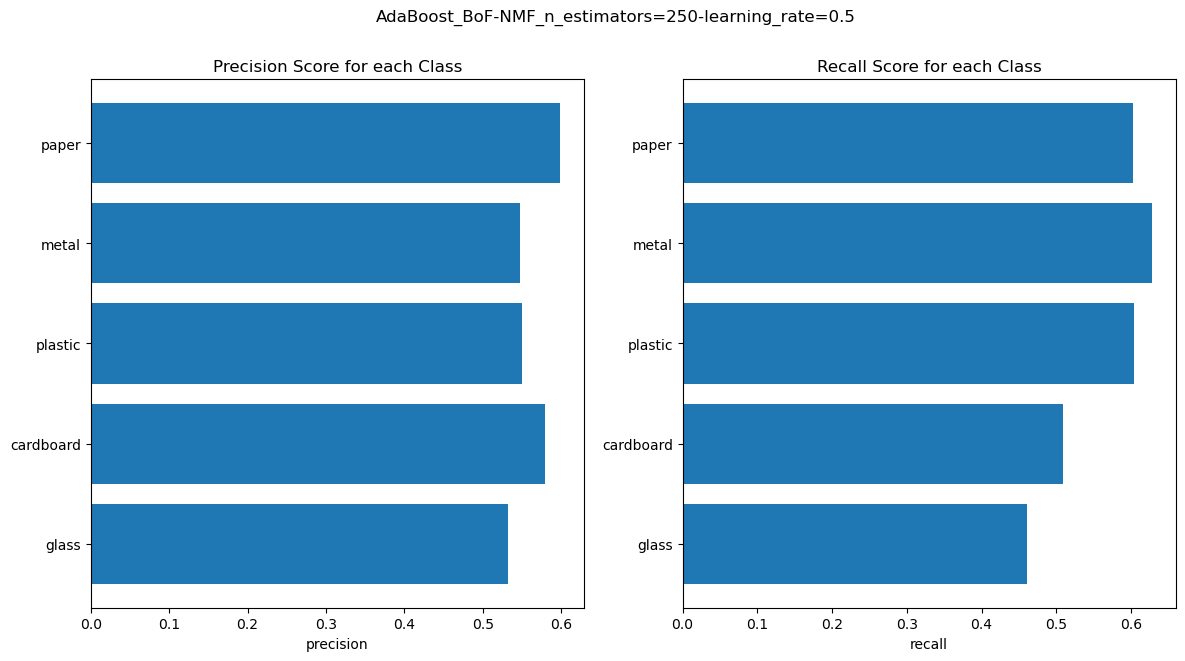

In [53]:
df, model_wrong_preds = multiclass_CV(model, 5, new_X_dict, y, param_dict, 
                                      param_title_dictionary, CLASSES, 
                                      model_name, path, image_filenames)

In [54]:
df

,model_name,accuracy,cardboard_f1_score,cardboard_precision,cardboard_recall,glass_f1_score,glass_precision,glass_recall,metal_f1_score,metal_precision,metal_recall,paper_f1_score,paper_precision,paper_recall,plastic_f1_score,plastic_precision,plastic_recall
0,AdaBoost_BoF_n_estimators=250-learning_rate=1,0.634195,0.65567,0.680942,0.632207,0.582075,0.589796,0.574553,0.615668,0.573883,0.664016,0.671273,0.666667,0.675944,0.648091,0.67382,0.624254
1,AdaBoost_BoF-PCA_n_estimators=250-learning_rat...,0.610338,0.623742,0.631365,0.616302,0.553279,0.570825,0.536779,0.595194,0.556131,0.640159,0.663306,0.672802,0.654076,0.616633,0.6294,0.604374
2,AdaBoost_BoF-PCA80_n_estimators=250-learning_r...,0.545129,0.514408,0.5553,0.479125,0.495745,0.533181,0.463221,0.555556,0.527728,0.586481,0.592381,0.568556,0.61829,0.559078,0.540892,0.578529
3,AdaBoost_BoF-NMF_n_estimators=250-learning_rat...,0.561034,0.541799,0.579186,0.508946,0.494143,0.53211,0.461233,0.584644,0.546713,0.628231,0.600595,0.598814,0.602386,0.575758,0.549729,0.604374


## Store Datasets

In [49]:
data_root = 'data/'

for dataset_key in new_X_dict.keys():
    
    X = new_X_dict[dataset_key].to_numpy()
    df = pd.DataFrame(np.hstack((X,np.expand_dims(y, axis=1))))
    csv_name = dataset_key + '_probabilities.csv'
    df.to_csv(os.path.join(data_root, csv_name))

## Print Most Wrong Prediction

In [ ]:
print_wrong_predictions(model_wrong_preds['BoF'], 10, image_generator, params)